In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
from collections import defaultdict
from datetime import datetime

from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from skimage import measure
from skimage.transform import resize

In [3]:
sys.path.append(os.path.join('../model'))

import importlib

import network_unet
import network_resnet
import functions
import generator

importlib.reload(network_unet)
importlib.reload(network_resnet)
importlib.reload(functions)
importlib.reload(generator)

<module 'generator' from '/notebooks/code/generator.py'>

In [4]:
from network_unet import UNet
from network_resnet import ResNet
from generator import Generator
from functions import iou_segmentation, iou_box, LearningRate

In [5]:
# load bounding box locations
box_locations = {}

temp = pd.read_csv(os.path.join('../data/stage_1_train_labels.csv'))
box_locations = defaultdict(list)

print('num of patients=', len(temp.patientId.unique()))
print('num of boxes=', len(temp))

for _,row in temp.iterrows():
    
    if row.Target==1:
        patientId=row.patientId
        box=[int(row.x), int(row.y), int(row.width), int(row.height)]
        box_locations[patientId].append(box)

num of patients= 25684
num of boxes= 28989


In [6]:
box_locations['640743e2-59ed-4859-b25b-eb92f351cef0']

[[662, 552, 182, 206]]

In [6]:
# load metadata
# metadata = pd.read_csv(os.path.join('../data/metadata.csv'))
# print(len(metadata))
# metadata.head()

In [7]:
# split training and validation
folder = '../data/stage_1_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
n_validation = 2560
train_filenames = filenames[n_validation:]
validation_filenames = filenames[:n_validation]
print('number of train samples=', len(train_filenames))
print('number of validation samples=', len(validation_filenames))

number of train samples= 23124
number of validation samples= 2560


In [8]:
# model parameter
BATCH_SIZE = 16
IMAGE_SIZE = 320
N_EPOCH = 5

In [19]:
#### Model 1 ####
# ResNet from Kaggle public kernel
# https://www.kaggle.com/jonnedtc/cnn-segmentation-connected-components

# # build model
# model = ResNet(input_size=IMAGE_SIZE, channels=32, n_blocks=2, depth=4)
# model.compile(optimizer='adam',
#               loss=keras.losses.binary_crossentropy,
#               metrics=[iou_segmentation])

# # visualize model
# # plot_model(ResNet, 'model.png', show_shapes=True)
# print(model.summary())

#### Model 2 ####
# UNet
# https://github.com/imlab-uiip/lung-segmentation-2d

# build model
model = UNet(input_shape=(IMAGE_SIZE,IMAGE_SIZE,1))
model.compile(optimizer='adam',
              loss=keras.losses.binary_crossentropy,
              metrics=[iou_segmentation])

# visualize model
# plot_model(UNet, 'model.png', show_shapes=True)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 320, 320, 1)  0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 320, 320, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 320, 320, 32) 9248        conv2d_22[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 160, 160, 32) 0           conv2d_23[0][0]                  
__________________________________________________________________________________________________
conv2d_24 

In [26]:
# callbacks
callbacks=[]
callback_lr = LearningRate(lr=0.0001)

# callback_checkpointer = ModelCheckpoint('model.{epoch:03d}.hdf5', period=1)
# callback_tb = TensorBoard(log_dir=os.path.join('../logs'), 
#                             histogram_freq=1, 
#                             batch_size=BATCH_SIZE, 
#                             write_graph=True, 
#                             write_grads=False, 
#                             write_images=False)

callbacks = [callback_lr]

In [27]:
# train model
folder = os.path.join('../data/stage_1_train_images')
train_gen = Generator(folder, 
                      train_filenames, 
                      box_locations, 
                      batch_size=BATCH_SIZE, 
                      image_size=IMAGE_SIZE, 
                      shuffle=True, 
                      augment=True, 
                      predict=False)

valid_gen = Generator(folder, 
                      validation_filenames, 
                      box_locations, 
                      batch_size=BATCH_SIZE, 
                      image_size=IMAGE_SIZE, 
                      shuffle=False, 
                      augment=False,
                      predict=False)

history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=callbacks, epochs=N_EPOCH, shuffle=True)

Epoch 1/5


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 982/1445 [===================>..........] - ETA: 3:57 - loss: 0.4350 - iou_segmentation: 0.0000e+00

KeyboardInterrupt: 

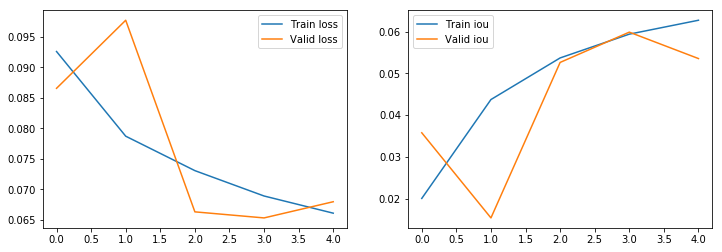

In [12]:
# visualize training history
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(122)
plt.plot(history.epoch, history.history["iou_segmentation"], label="Train iou")
plt.plot(history.epoch, history.history["val_iou_segmentation"], label="Valid iou")
plt.legend()
plt.show()

In [18]:
# predict validation images
prob_thresholds = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
nthresh = len(prob_thresholds)

# load validation filenames
folder = os.path.join('../data/stage_1_train_images')
test_filenames = validation_filenames
print('number of test samples=', len(test_filenames))

# create test generator with predict flag set to True
test_gen = Generator(folder, test_filenames, None, batch_size=25, 
                     image_size=IMAGE_SIZE, shuffle=False, predict=True)

# loop through validation set
count = 0
ns = nthresh*[0]
nfps = nthresh*[0]
ntps = nthresh*[0]
overall_maps = nthresh*[0.]
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        count = count + 1
        maxpred = np.max(pred)
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        boxes_preds = []
        scoress = []
        for thresh in prob_thresholds:
            comp = pred[:, :, 0] > thresh
            # apply connected components
            comp = measure.label(comp)
            # apply bounding boxes
            boxes_pred = np.empty((0,4),int)
            scores = np.empty((0))
            for region in measure.regionprops(comp):
                # retrieve x, y, height and width
                y, x, y2, x2 = region.bbox
                boxes_pred = np.append(boxes_pred, [[x, y, x2-x, y2-y]], axis=0)
                # proxy for confidence score
                conf = np.mean(pred[y:y2, x:x2])
                scores = np.append( scores, conf )
            boxes_preds = boxes_preds + [boxes_pred]
            scoress = scoress + [scores]
        boxes_true = np.empty((0,4),int)
        fn = filename.split('.')[0]
        
        # if image contains pneumonia
        if fn in box_locations:
            # loop through pneumonia
            for location in box_locations[fn]:
                x, y, w, h = location
                boxes_true = np.append(boxes_true, [[x, y, w, h]], axis=0)
        for i in range(nthresh):
            if (boxes_true.shape[0]==0 and boxes_preds[i].shape[0]>0):
                ns[i] = ns[i] + 1
                nfps[i] = nfps[i] + 1
            elif (boxes_true.shape[0]>0):
                ns[i] = ns[i] + 1
                contrib = iou_box(boxes_true, boxes_preds[i], scoress[i]) 
                overall_maps[i] = overall_maps[i] + contrib
                if (boxes_preds[i].shape[0]>0):
                    ntps[i] = ntps[i] + 1

    # stop if we've got them all
    if count >= len(test_filenames):
        break

for i, thresh in enumerate(prob_thresholds):
    print("\nProbability threshold=", thresh)
    overall_maps[i] = overall_maps[i] / (ns[i]+1e-7)
    print("False positive cases=", nfps[i])
    print("True positive cases=", ntps[i])
    print("Overall evaluation score=", overall_maps[i])

number of test samples= 2560


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Probability threshold= 0.15
False positive cases= 926
True positive cases= 492
Overall evaluation score= 0.08090968885283167

Probability threshold= 0.2
False positive cases= 711
True positive cases= 462
Overall evaluation score= 0.0944662506633549

Probability threshold= 0.25
False positive cases= 539
True positive cases= 431
Overall evaluation score= 0.10015576323051506

Probability threshold= 0.3
False positive cases= 402
True positive cases= 383
Overall evaluation score= 0.09818908537711449

Probability threshold= 0.35
False positive cases= 323
True positive cases= 336
Overall evaluation score= 0.0877903005361682

Probability threshold= 0.4
False positive cases= 262
True positive cases= 304
Overall evaluation score= 0.07690994114204583

Probability threshold= 0.45
False positive cases= 188
True positive cases= 263
Overall evaluation score= 0.06706363003239728

Probability threshold= 0.5
False positive cases= 137
True positive cases= 220
Overall evaluation score= 0.0554360029857131

In [ ]:
# save model to disk for testing
model_path = 'model'+datetime.now().strftime("%Y%m%d_%H:%M:%S")+'.hdf5'
model.save(os.path.join(model_path))